In [1]:
%matplotlib widget

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Try to preview the images

color_image = cv.imread('../data/small_box/color_image.png')
depth_image = cv.imread('../data/small_box/raw_depth.png')
depth_display = cv.normalize(depth_image, None, 0, 255, cv.NORM_MINMAX)
depth_display = depth_display.astype(np.uint8)
print("depth: ", depth_image.shape)
print("RGB", color_image.shape)

depth:  (480, 640, 3)
RGB (480, 640, 3)


In [3]:
import open3d as o3d

# Load .ply file
ply_file_path = "../data/small_box/small_box_10_raw.ply"
pcd = o3d.io.read_point_cloud(ply_file_path)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW Error: X11: Failed to open display 1
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


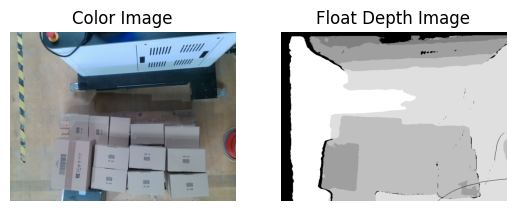

In [4]:
plt.subplot(121)
plt.imshow(cv.cvtColor(color_image, cv.COLOR_BGR2RGB))
plt.title('Color Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(depth_display,'plasma')
plt.title('Float Depth Image')
plt.axis('off')
plt.show()



### Extract images to create synthetic dataset


Box 0 is nearly square, skipping rotation.


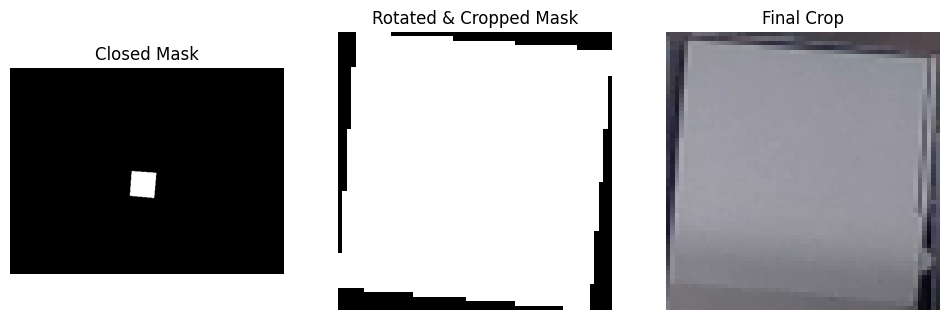

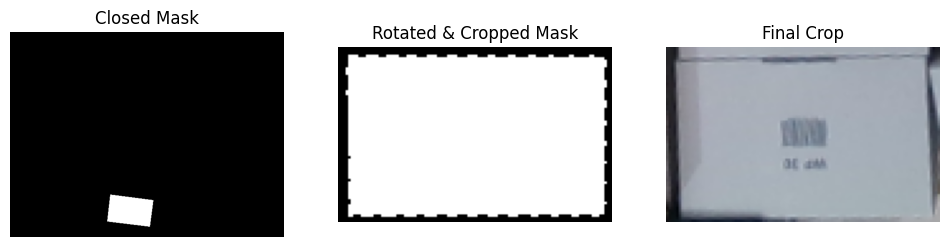

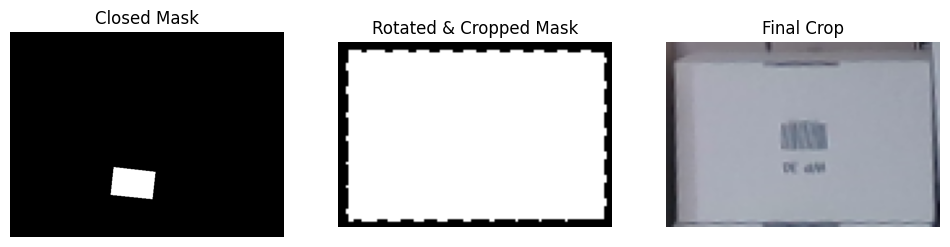

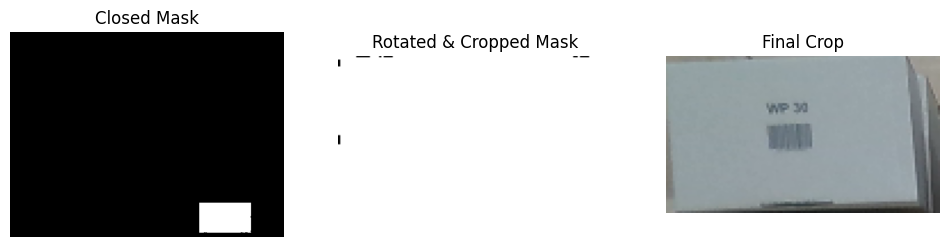

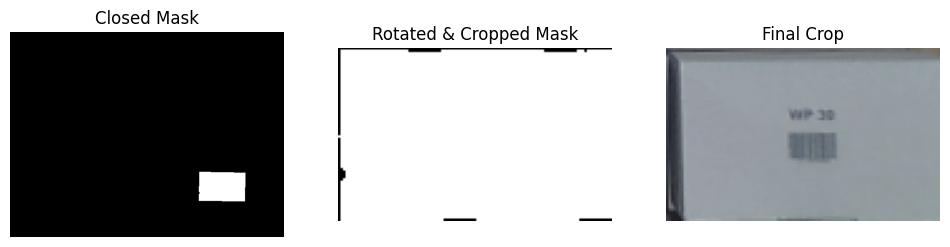

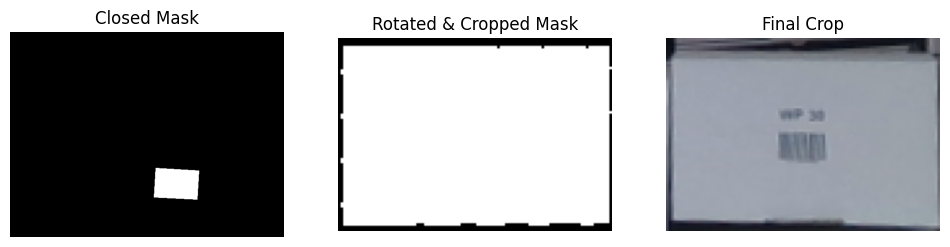

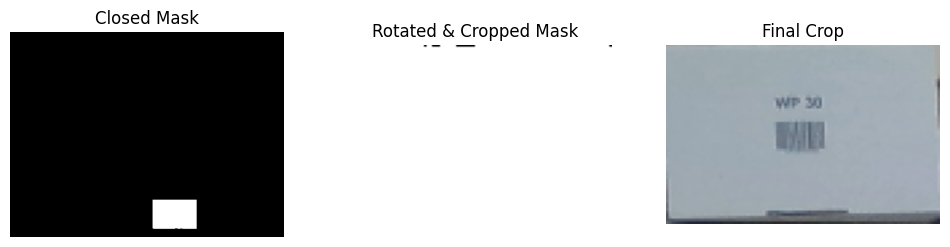

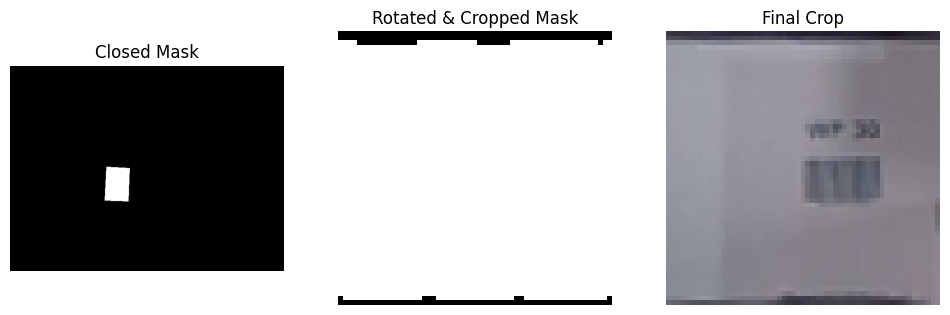

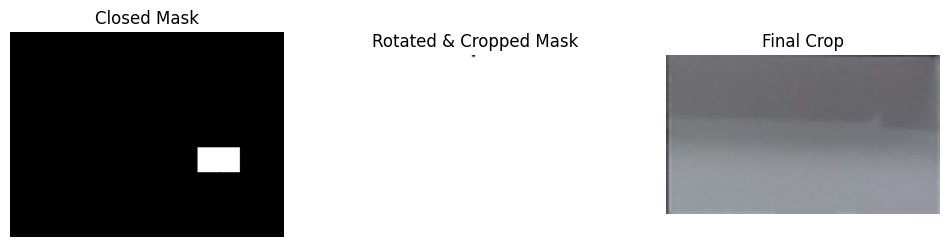

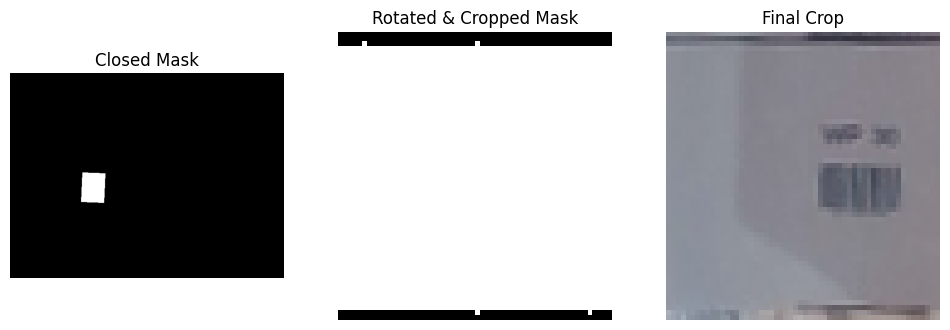

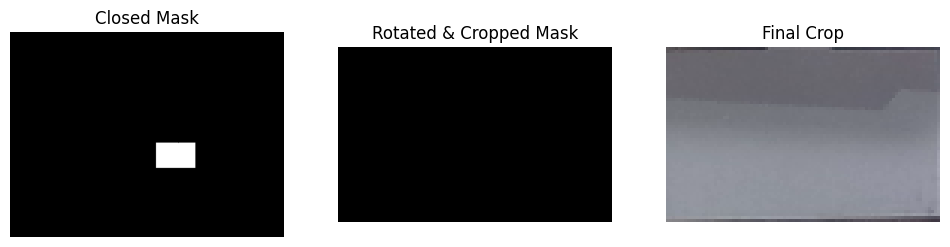

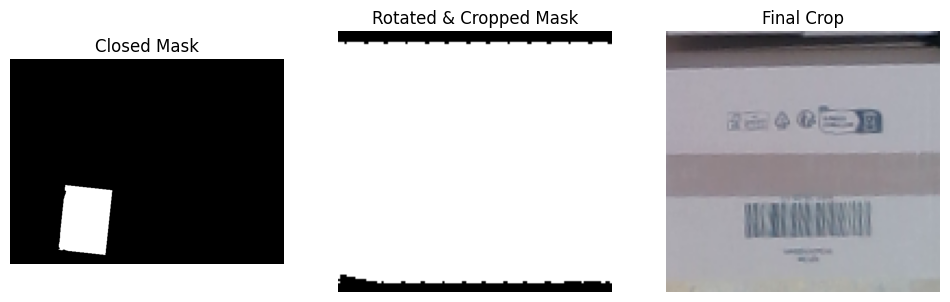

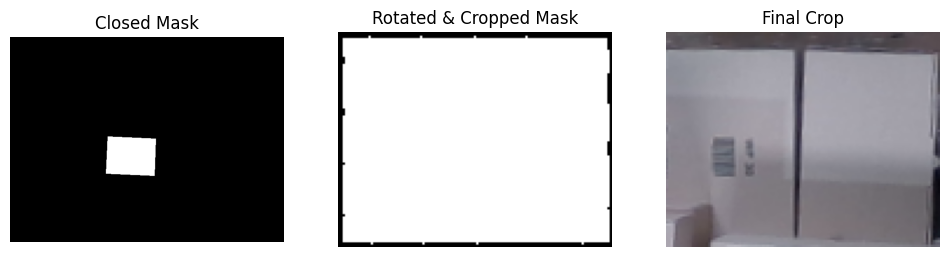

Mask image 2 not found, skipping.


[ WARN:0@1734.009] global loadsave.cpp:268 findDecoder imread_('../data/medium_box/medium_box_mask_2.png'): can't open/read file: check file path/integrity


In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

classes = [
    {'name': 'small_box', 'size': 10},
    {'name': 'medium_box', 'size': 2},
]

for cls in classes:
    # Load the 2D image
    image_2d = cv.imread(f'../data/{cls["name"]}/color_image.png')

    for i in range(cls['size'] + 1):
        # Load mask and create binary image
        mask = cv.imread(f'../data/{cls["name"]}/{cls["name"]}_mask_{i}.png', cv.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Mask image {i} not found, skipping.")
            continue

        # Otsu's thresholding for robustness
        _, binary_mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

        # Morphological closing to fill small holes
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
        mask = cv.morphologyEx(binary_mask, cv.MORPH_CLOSE, kernel)

        # Find contours and get largest one
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        if not contours:
            print(f"No contours found in mask {i}, skipping.")
            continue

        max_contour = max(contours, key=cv.contourArea)

        # Get rotated rectangle and angle correction
        rotated_box = cv.minAreaRect(max_contour)
        (cx, cy), (w, h), angle = rotated_box

        # Aspect ratio check: skip rotation for near-square boxes
        aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 0
        if aspect_ratio < 1.2:
            print(f"Box {i} is nearly square, skipping rotation.")
            x, y, bw, bh = cv.boundingRect(max_contour)
            final_crop = image_2d[y:y+bh, x:x+bw]
            rotated_mask = mask[y:y+bh, x:x+bw]
        else:
            # Ensure the longest side is horizontal
            if w < h:
                angle += 90
                w, h = h, w  # Swap dimensions

            # Get rotation matrix and calculate new size
            rot_mat = cv.getRotationMatrix2D((cx, cy), angle, 1)
            cos = np.abs(rot_mat[0, 0])
            sin = np.abs(rot_mat[0, 1])
            new_w = int((h * sin) + (w * cos))
            new_h = int((h * cos) + (w * sin))

            # Adjust rotation matrix center
            rot_mat[0, 2] += (new_w / 2) - cx
            rot_mat[1, 2] += (new_h / 2) - cy

            # Apply rotation to both mask and color image
            rotated_mask = cv.warpAffine(mask, rot_mat, (new_w, new_h), flags=cv.INTER_NEAREST)
            rotated_color = cv.warpAffine(image_2d, rot_mat, (new_w, new_h))

            # Find tight bounding box after rotation
            ys, xs = np.where(rotated_mask > 0)
            if len(xs) == 0 or len(ys) == 0:
                print(f"No nonzero pixels in rotated mask {i}, skipping.")
                continue
            min_x, max_x = np.min(xs), np.max(xs)
            min_y, max_y = np.min(ys), np.max(ys)

            # Smart padding: 5% of box size
            pad_x = int((max_x - min_x) * 0.05)
            pad_y = int((max_y - min_y) * 0.05)
            crop_y1 = max(0, min_y - pad_y)
            crop_y2 = min(rotated_color.shape[0], max_y + pad_y)
            crop_x1 = max(0, min_x - pad_x)
            crop_x2 = min(rotated_color.shape[1], max_x + pad_x)
            final_crop = rotated_color[crop_y1:crop_y2, crop_x1:crop_x2]
            rotated_mask = rotated_mask[crop_y1:crop_y2, crop_x1:crop_x2]

        # Save result
        if not os.path.exists(f'../data/templates/{cls["name"]}'):
            os.makedirs(f'../data/templates/{cls["name"]}')
        cv.imwrite(f'../data/templates/{cls["name"]}/image_{i}.png', final_crop)
        cv.imwrite(f'../data/templates/{cls["name"]}/mask_{i}.png', rotated_mask)

        # Visualization (optional)
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(mask, cmap='gray')
        plt.title('Closed Mask')
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(rotated_mask, cmap='gray')
        plt.title('Rotated & Cropped Mask')
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(cv.cvtColor(final_crop, cv.COLOR_BGR2RGB))
        plt.title('Final Crop')
        plt.axis('off')
        plt.show()


In [16]:
import numpy as np
from PIL import Image
from pathlib import Path
import os

def generate_random_backgrounds(num_backgrounds=100, image_size=(720, 1280), out_dir="../data/backgrounds"):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    for i in range(num_backgrounds):
        # Random noise
        background = np.random.randint(0, 256, (image_size[0], image_size[1], 3), dtype=np.uint8)
        # Optional: Add a gradient for more variety
        if np.random.rand() > 0.5:
            x = np.linspace(0, 1, image_size[1])
            y = np.linspace(0, 1, image_size[0])
            xv, yv = np.meshgrid(x, y)
            gradient = ((xv + yv) * 128).astype(np.uint8)
            background = np.clip(background * 0.5 + gradient[..., None], 0, 255).astype(np.uint8)
        Image.fromarray(background).save(out_dir / f"background_{i:04d}.jpg", quality=85)
    print(f"Generated {num_backgrounds} backgrounds in {out_dir.absolute()}")

# Run this once to create backgrounds
generate_random_backgrounds(num_backgrounds=100, image_size=(720, 1280))


Generated 100 backgrounds in /workspace/data_exploratary/../data/backgrounds


In [20]:
import cv2
import numpy as np
import albumentations as A
from pathlib import Path
import random

# Configuration
NUM_SYNTHETIC_IMAGES = 1000
BOXES_PER_IMAGE = (3, 8)
BACKGROUND_DIR = Path("../data/backgrounds")
TEMPLATE_ROOT = Path("../data/templates")
OUTPUT_DIR = Path("../data/dataset")
IMAGE_SIZE = (1280, 720)  # width, height

# Load backgrounds
background_paths = list(BACKGROUND_DIR.glob("*.jpg"))
backgrounds = [cv2.imread(str(p)) for p in background_paths if cv2.imread(str(p)) is not None]

# Load templates with masks for each class
class_dirs = [d for d in TEMPLATE_ROOT.iterdir() if d.is_dir()]
class_templates = {}
for class_id, class_dir in enumerate(sorted(class_dirs)):
    templates = []
    for img_path in class_dir.glob("image_*.png"):
        mask_path = class_dir / f"mask_{img_path.stem.split('_')[-1]}.png"
        if not mask_path.exists():
            continue

        img = cv2.imread(str(img_path))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if img is not None and mask is not None:
            templates.append((img, mask))

    if not templates:
        raise FileNotFoundError(f"No valid image/mask pairs in {class_dir}")
    class_templates[class_id] = templates

num_classes = len(class_templates)

# Albumentations pipeline (applies same transforms to image and mask)
box_aug = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomScale(scale_limit=0.2, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Blur(blur_limit=3, p=0.1),
    A.CLAHE(p=0.2)
], additional_targets={'mask': 'image'})

# Output directories
for split in ["train", "val"]:
    (OUTPUT_DIR/f"{split}/images").mkdir(parents=True, exist_ok=True)
    (OUTPUT_DIR/f"{split}/labels").mkdir(parents=True, exist_ok=True)

def apply_mask(image, mask):
    """Apply mask to image using bitwise operations"""
    mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
    return cv2.bitwise_and(image, image, mask=mask)

# Synthetic image generation
for img_idx in range(NUM_SYNTHETIC_IMAGES):
    bg = cv2.resize(random.choice(backgrounds), IMAGE_SIZE)
    h, w = bg.shape[:2]
    annotations = []
    placed_boxes = []
    num_boxes = random.randint(*BOXES_PER_IMAGE)

    for _ in range(num_boxes):
        class_id = random.choice(list(class_templates.keys()))
        template_img, template_mask = random.choice(class_templates[class_id])

        # Augment both image and mask together
        augmented = box_aug(image=template_img, mask=template_mask)
        aug_img = augmented["image"]
        aug_mask = augmented["mask"]

        # Clean up mask
        _, clean_mask = cv2.threshold(aug_mask, 127, 255, cv2.THRESH_BINARY)
        bh, bw = clean_mask.shape[:2]

        # Find non-zero area in mask
        ys, xs = np.where(clean_mask > 0)
        if len(xs) == 0 or len(ys) == 0:
            continue

        # Get tight bounding box from mask
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        bw = max_x - min_x
        bh = max_y - min_y

        # Crop to mask content
        aug_img = aug_img[min_y:max_y, min_x:max_x]
        clean_mask = clean_mask[min_y:max_y, min_x:max_x]
        bh, bw = clean_mask.shape[:2]

        # Find valid position with collision check
        max_attempts = 100
        for _ in range(max_attempts):
            x = random.randint(0, w - bw)
            y = random.randint(0, h - bh)
            new_box = (x, y, x+bw, y+bh)

            overlap = any(
                (new_box[0] < ex[2] and new_box[2] > ex[0] and
                 new_box[1] < ex[3] and new_box[3] > ex[1])
                for ex in placed_boxes
            )

            if not overlap:
                placed_boxes.append(new_box)
                break
        else:
            continue  # Skip if no position found

        # Apply mask and blend with background
        masked_object = apply_mask(aug_img, clean_mask)
        roi = bg[y:y+bh, x:x+bw]

        # Create inverse mask for blending
        inv_mask = cv2.bitwise_not(clean_mask)
        bg_region = cv2.bitwise_and(roi, roi, mask=inv_mask)
        combined = cv2.add(bg_region, masked_object)
        bg[y:y+bh, x:x+bw] = combined

        # YOLO annotation (normalized)
        x_center = (x + bw/2) / w
        y_center = (y + bh/2) / h
        width = bw / w
        height = bh / h
        annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Save results
    split = "train" if img_idx < NUM_SYNTHETIC_IMAGES * 0.9 else "val"
    cv2.imwrite(str(OUTPUT_DIR/f"{split}/images/{img_idx:04d}.jpg"), bg)
    with open(OUTPUT_DIR/f"{split}/labels/{img_idx:04d}.txt", "w") as f:
        f.write("\n".join(annotations))

    if img_idx % 100 == 0:
        print(f"Generated {img_idx}/{NUM_SYNTHETIC_IMAGES} images")

print("Synthetic dataset generation complete.")


Generated 0/1000 images
Generated 100/1000 images
Generated 200/1000 images
Generated 300/1000 images
Generated 400/1000 images
Generated 500/1000 images
Generated 600/1000 images
Generated 700/1000 images
Generated 800/1000 images
Generated 900/1000 images
Synthetic dataset generation complete.


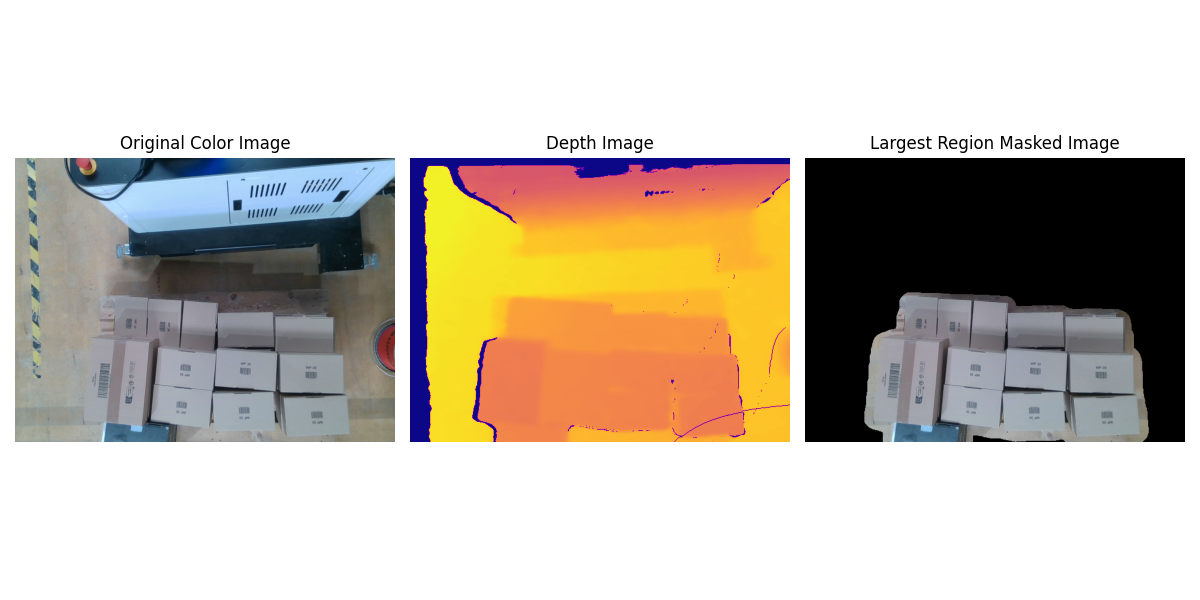

In [29]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Read images
color_image = cv.imread('../data/small_box/color_image.png')
depth_image = cv.imread('../data/small_box/raw_depth.png', cv.IMREAD_ANYDEPTH)  # Read as depth image

# Convert depth to display format
depth_display = cv.normalize(depth_image, None, 0, 255, cv.NORM_MINMAX)
depth_display = depth_display.astype(np.uint8)

# Threshold the depth and create mask
min_val = 1390
max_val = 1766
depth_mask = ((depth_image > min_val) & (depth_image < max_val)).astype(np.uint8) * 255

# Ensure mask is 2D and matches color image dimensions
if depth_mask.ndim == 3:
    depth_mask = cv.cvtColor(depth_mask, cv.COLOR_BGR2GRAY)
if depth_mask.shape != color_image.shape[:2]:
    depth_mask = cv.resize(depth_mask, (color_image.shape[1], color_image.shape[0]))

# Morphological operations
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (30, 30))
depth_mask = cv.morphologyEx(depth_mask, cv.MORPH_CLOSE, kernel)
depth_mask = cv.dilate(depth_mask, kernel, iterations=1)

# Find the largest connected component
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(depth_mask, connectivity=8)

# Find the largest component (excluding the background)
largest_label = 1 + np.argmax(stats[1:, cv.CC_STAT_AREA])  # Skip background (label 0)
largest_region = (labels == largest_label).astype(np.uint8) * 255

# Apply the largest region mask to the color image
masked_color = cv.bitwise_and(color_image, color_image, mask=largest_region)
masked_color = cv.cvtColor(masked_color, cv.COLOR_BGR2RGB)

# Display images
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(cv.cvtColor(color_image, cv.COLOR_BGR2RGB))
plt.title('Original Color Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(depth_display, cmap='plasma')
plt.title('Depth Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(masked_color)
plt.title('Largest Region Masked Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load model
model = YOLO('/workspace/data/model/best.pt')

# Load image for detection
img_path = "/workspace/data/small_box/color_image.png"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Could not load image: {img_path}")

depth_mask = largest_region
# Run inference
results = model(img)

# Create visualization canvas
result_img = img.copy()

# Create figure for matplotlib visualization
plt.figure(figsize=(16, 10))

# Filter detections based on mask
filtered_boxes = []
total_boxes = len(results[0].boxes)
filtered_count = 0

for i, box in enumerate(results[0].boxes):
    cls = int(box.cls[0])
    conf = float(box.conf[0])
    xyxy = box.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
    x1, y1, x2, y2 = map(int, xyxy)

    # Get class name for display
    class_name = model.names[cls]

    # Check if center point is in mask
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Ensure coordinates are within mask bounds
    if 0 <= center_y < depth_mask.shape[0] and 0 <= center_x < depth_mask.shape[1]:
        is_in_mask = depth_mask[center_y, center_x] > 0
    else:
        is_in_mask = False

    # Set color and line type based on mask inclusion
    if is_in_mask:
        filtered_count += 1
        filtered_boxes.append((cls, conf, xyxy))
        # Green for boxes inside mask
        color = (0, 255, 0)
        line_type = cv2.LINE_AA
    else:
        continue
        # Red for boxes outside mask
        color = (0, 0, 255)
        line_type = cv2.LINE_AA

    # Draw rectangle
    cv2.rectangle(result_img, (x1, y1), (x2, y2), color, 2, line_type)

    # Add label with class name and confidence
    label = f"{class_name} {conf:.2f}"
    text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
    cv2.rectangle(result_img, (x1, y1-text_size[1]-5), (x1+text_size[0], y1), color, -1)
    cv2.putText(result_img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

# Display results using matplotlib (better for Colab)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title(f'Detections: {filtered_count}/{total_boxes} inside mask')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print filtered detection details
print(f"Found {len(filtered_boxes)} boxes inside the mask:")
for cls, conf, xyxy in filtered_boxes:
    class_name = model.names[cls]
    print(f"Class: {class_name}, Confidence: {conf:.2f}, Box: {xyxy}")

# Optional: Calculate area percentage overlap for each box
print("\nDetailed mask overlap analysis:")
for cls, conf, xyxy in filtered_boxes:
    class_name = model.names[cls]
    x1, y1, x2, y2 = map(int, xyxy)

    # Get region of mask corresponding to bounding box
    box_mask = depth_mask[y1:y2, x1:x2]

    # Calculate overlap percentage
    mask_area_percentage = np.count_nonzero(box_mask) / ((y2-y1) * (x2-x1)) if ((y2-y1) * (x2-x1)) > 0 else 0

    print(f"{class_name}: {conf:.2f} - Mask overlap: {mask_area_percentage:.2%}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


NameError: name 'largest_region' is not defined